In [ ]:
  from google.colab import drive
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

drive.mount('/content/drive')

base = '/content/drive/My Drive/Segmentation Through the Clouds/DBX3/DBX'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test_img = "/content/drive/My Drive/Segmentation Through the Clouds/DBX3/TRAIN/Tile 3/images/image_part_008.jpg"
test_mask = "/content/drive/My Drive/Segmentation Through the Clouds/DBX3/TRAIN/Tile 3/masks/image_part_008.png"

In [ ]:
rgb_mask = np.array(Image.open(test_mask))
print(np.unique(rgb_mask))

[ 16  41  58  60 110 132 152 155 169 193 221 226 228 246 254]


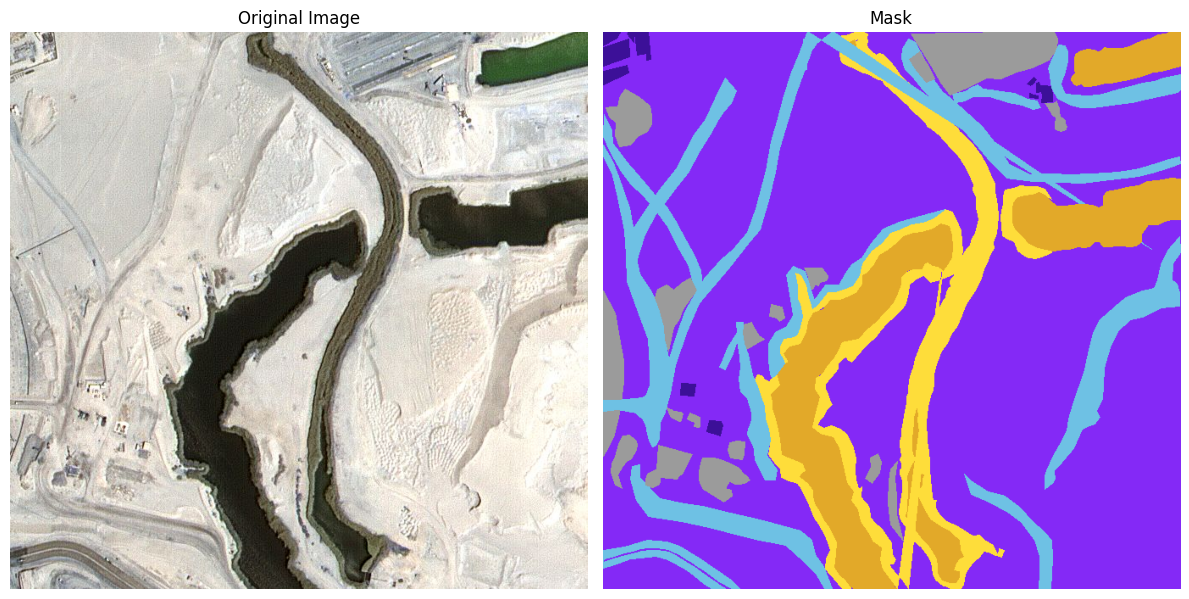

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(Image.open(test_img))
ax1.axis('off')
ax1.set_title('Original Image')

ax2.imshow(Image.open(test_mask))
ax2.axis('off')
ax2.set_title('Mask')

plt.tight_layout()
plt.show()


In [ ]:
rgb_image = np.array(Image.open(test_img))
# print(np.unique(rgb_image))

In [ ]:
print(rgb_mask.shape)

(658, 682, 3)


In [ ]:
print(rgb_image.shape)

(658, 682, 3)


In [ ]:
# def split_image(image_path, output_dir, isMask):
#   with Image.open(image_path) as img:
#       width, height = img.size
#       # print(f"{width},{height}")
#       base_name = os.path.splitext(os.path.basename(image_path))[0]
#       x_splits = width // (width//2)
#       y_splits = height // (height//2)

#       for i in range(y_splits):
#           for j in range(x_splits):
#               left = j * width//2
#               right = (j + 1) * width//2
#               upper = i * height//2
#               lower = (i + 1) * height//2

#               dim = (left, upper, right, lower)
#               split = img.crop(dim)
#               # print(f"{split.size}")
#               if(isMask==True):
#                 filename = f"{base_name}_split_{i}_{j}.png"
#               else:
#                 filename = f"{base_name}_split_{i}_{j}.jpg"
#               # print(filename)
#               output_path = os.path.join(output_dir, filename)
#               # print(output_path)
#               split.save(output_path)

# # for tile in []:
# # for tile in ['Tile 3', 'Tile 4', 'Tile 5', 'Tile 6', 'Tile 7', 'Tile 8']:
#     image_dir = os.path.join(base, tile, 'images')

#     for image in os.listdir(image_dir):
#         if image.endswith('.jpg'):
#             image_path = os.path.join(image_dir, image)
#             split_image(image_path, image_dir, isMask=False)

#     mask_dir = os.path.join(base, tile, 'masks')

#     for mask in os.listdir(mask_dir):
#         if mask.endswith('.png'):
#             mask_path = os.path.join(mask_dir, mask)
#             split_image(mask_path, mask_dir, isMask=True)



In [ ]:
rgb_image = np.array(Image.open(test_mask))
print(np.unique(rgb_image.reshape(-1, rgb_image.shape[2]), axis=0))

[[ 60  16 152]
 [110 193 228]
 [132  41 246]
 [155 155 155]
 [226 169  41]
 [254 221  58]]


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, num_classes=6):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.num_classes = num_classes
        self.images = self._load_images(self.images_dir)

    def _load_images(self, directory):
        """Traverse through the main directory and subdirectories to gather all image paths"""
        image_paths = []
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith('.jpg'):  # images are in '.jpg' format
                    image_paths.append(os.path.join(root, file))
        return image_paths

    def __len__(self):
        return len(self.images)

    # def __getitem__(self, idx):
    #     img_path = self.images[idx]
    #     mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')  # masks are in '.png' format

    #     image = Image.open(img_path)
    #     mask = Image.open(mask_path).convert("RGB")

    #     # print(np.unique(np.array(mask)))
    #     class_indices_mask = rgb_to_class_indices(np.array(mask))
    #     print(np.unique(class_indices_mask))
    #     if self.transform:
    #         image = self.transform(image)
    #         mask = self.transform(mask)

    #     class_indices_mask = np.array(class_indices_mask).transpose(1, 2, 0)  # Convert to (512, 512, 3)
    #     # class_indices_mask = rgb_to_class_indices(rgb_mask)
    #     # print(f"masks : {np.unique(class_indices_mask)}")

    #     return image, torch.tensor(class_indices_mask, dtype=torch.long) # image -> (512, 512, 3) and class_indices_mask -> 512, 512

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')

        image = Image.open(img_path)
        mask = Image.open(mask_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
            mask = mask_transform(mask)
        class_indices_mask = rgb_to_class_indices(np.array(mask))
        # print(f"Unique class indices in mask: {np.unique(class_indices_mask)}")

        class_indices_mask = torch.tensor(class_indices_mask)

        # print(np.unique(class_indices_mask.cpu()))
        return image, class_indices_mask

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512))
])

In [ ]:
colormap = {
    0: [60, 16, 152],   # Class 0: Water
    1: [110, 193, 228], # Class 1: Land (unpaved area)
    2: [132, 41, 246],  # Class 2: Road
    3: [155, 155, 155], # Class 3: Building
    4: [226, 169, 41],  # Class 4: Vegetation
    5: [254, 221, 58]   # Class 5: Unlabeled
}
def rgb_to_class_indices(rgb_image, colormap=colormap):                                       # height x width x 3 -> height x width
    class_indices = np.zeros((rgb_image.shape[0], rgb_image.shape[1]), dtype=np.int64)

    for i, cls in enumerate(colormap):
        class_indices[np.all(rgb_image == colormap[cls], axis=-1)] = cls
    return class_indices

def convert_to_rgb(prediction, color_map = colormap):
    rgb_image = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.int64)
    for class_index, color in color_map.items():
        rgb_image[prediction == class_index] = color
    return rgb_image


In [ ]:
rgb_mask = Image.open(test_mask)
ind_mask = rgb_to_class_indices(np.array(rgb_mask))
np.unique(ind_mask)

array([0, 1, 2, 3, 4, 5])

In [ ]:
print(ind_mask.shape)

(658, 682)


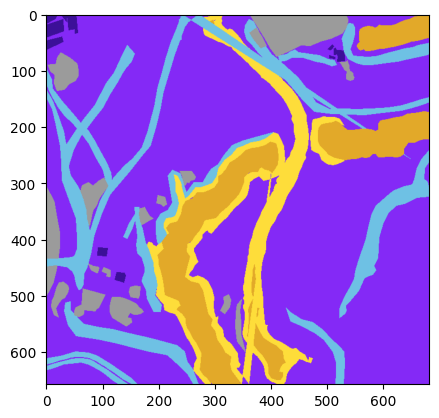

In [ ]:
rgb_mask = convert_to_rgb(ind_mask)
plt.imshow(rgb_mask)

In [ ]:
class DoubleConv(nn.Module):
    # (convolution -> [BN] -> ReLU) * 2

    # mid _channels -> used to control the number of channels between the first and the second convolution layers

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        # kernel_size=3 -> a 3x3 kernel is used to perform the convolutions
        # padding=1 -> ensures that the height and width of the image remains the same after the convolution (adds a border of zeros around the image)

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    # Downscaling with maxpool then double conv

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    # Upscaling then double conv

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        # double the height and width of the images by taking the average of the pixels around
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)    #(deconvolution) double the height and width and reduce the channels by a factor of 2
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 -> the upscaled tensor
        # x2 -> the corresponding down-scaled tensor
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]   # differences in height of the tensors whose feature maps are to be concatenated
        diffX = x2.size()[3] - x1.size()[3]   # differences in width of the tensors whose feature maps are to be concatenated

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])   # [left, right, top, bottom]

        x = torch.cat([x2, x1], dim=1)  # concatinate the two tensors according to the u net architecture (allows the model to utilize both the high-level abstract
                                        # features from the decoder and the fine-grained details from the encoder); concatinate (the feature-maps of x1, x2 ) along the feature-map's dimention
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
# constructing the u net architecture
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels # 3
        self.n_classes = n_classes # 6
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))     # 3 -> 64
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))      # 64 -> 6

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)   # logits -> raw outputs produced by the final convolutional layer
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [ ]:
train_images_dir = "/content/drive/My Drive/Segmentation Through the Clouds/DBX3/TRAIN"
train_masks_dir = "/content/drive/My Drive/Segmentation Through the Clouds/DBX3/TRAIN"
val_images_dir = "/content/drive/My Drive/Segmentation Through the Clouds/DBX3/TEST"
val_masks_dir = "/content/drive/My Drive/Segmentation Through the Clouds/DBX3/TEST"


train_dataset = SegmentationDataset(train_images_dir, train_masks_dir, transform)
val_dataset = SegmentationDataset(val_images_dir, val_masks_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

n_channels = 3  # rgb
n_classes = 6   # Number of output classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels, n_classes).to(device)

criterion = nn.CrossEntropyLoss()  # used for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_dataset, train_loader

(<__main__.SegmentationDataset at 0x7b1fa4589570>,
 <torch.utils.data.dataloader.DataLoader at 0x7b1fa4589f00>)

In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f'', unit=''):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()

        outputs = model(images)  # Forward pass
        loss = criterion(outputs, masks)  # calculate loss

        # print(f"masks : {np.unique(masks.cpu())}")
        # print(f"outputs : {np.unique(outputs.detach().cpu().numpy())}")

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Training Loss: {epoch_loss:.4f}')

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)  # Forward pass
            # print(np.unique(masks.cpu()))
            # print(np.unique(outputs.cpu()))

            loss = criterion(outputs, masks)  # Calculate loss

            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}')

print("Training completed.")


100%|██████████| 7/7 [00:16<00:00,  2.34s/]


Training Loss: 1.2796
Validation Loss: 1.4664


100%|██████████| 7/7 [00:16<00:00,  2.35s/]


Training Loss: 0.9833
Validation Loss: 1.0655


100%|██████████| 7/7 [00:16<00:00,  2.37s/]


Training Loss: 0.8740
Validation Loss: 0.9487


100%|██████████| 7/7 [00:16<00:00,  2.40s/]


Training Loss: 0.8240
Validation Loss: 0.9663


100%|██████████| 7/7 [00:17<00:00,  2.49s/]


Training Loss: 0.8404
Validation Loss: 0.9360


100%|██████████| 7/7 [00:16<00:00,  2.42s/]


Training Loss: 0.7817
Validation Loss: 0.9751


100%|██████████| 7/7 [00:16<00:00,  2.40s/]


Training Loss: 0.7352
Validation Loss: 0.8131


100%|██████████| 7/7 [00:17<00:00,  2.45s/]


Training Loss: 0.7769
Validation Loss: 0.8023


100%|██████████| 7/7 [00:16<00:00,  2.42s/]


Training Loss: 0.7943
Validation Loss: 0.9141


100%|██████████| 7/7 [00:17<00:00,  2.46s/]


Training Loss: 0.7488
Validation Loss: 0.5675


100%|██████████| 7/7 [00:16<00:00,  2.42s/]


Training Loss: 0.7389
Validation Loss: 0.5849


100%|██████████| 7/7 [00:16<00:00,  2.43s/]


Training Loss: 0.7458
Validation Loss: 0.8528


100%|██████████| 7/7 [00:17<00:00,  2.50s/]


Training Loss: 0.6940
Validation Loss: 0.5674


100%|██████████| 7/7 [00:17<00:00,  2.44s/]


Training Loss: 0.6744
Validation Loss: 0.7202


100%|██████████| 7/7 [00:16<00:00,  2.42s/]


Training Loss: 0.6692
Validation Loss: 0.6382


100%|██████████| 7/7 [00:17<00:00,  2.45s/]


Training Loss: 0.6850
Validation Loss: 0.5537


100%|██████████| 7/7 [00:16<00:00,  2.41s/]


Training Loss: 0.7402
Validation Loss: 0.5577


100%|██████████| 7/7 [00:17<00:00,  2.47s/]


Training Loss: 0.6537
Validation Loss: 0.5785


100%|██████████| 7/7 [00:16<00:00,  2.41s/]


Training Loss: 0.7268
Validation Loss: 0.5720


100%|██████████| 7/7 [00:16<00:00,  2.41s/]


Training Loss: 0.7044
Validation Loss: 0.5847


100%|██████████| 7/7 [00:17<00:00,  2.45s/]


Training Loss: 0.6317
Validation Loss: 0.5670


100%|██████████| 7/7 [00:16<00:00,  2.41s/]


Training Loss: 0.6715
Validation Loss: 0.6154


100%|██████████| 7/7 [00:17<00:00,  2.45s/]


Training Loss: 0.6613
Validation Loss: 0.5447


100%|██████████| 7/7 [00:17<00:00,  2.44s/]


Training Loss: 0.6427
Validation Loss: 0.5119


100%|██████████| 7/7 [00:17<00:00,  2.43s/]


Training Loss: 0.6423
Validation Loss: 0.5526


100%|██████████| 7/7 [00:17<00:00,  2.50s/]


Training Loss: 0.6666
Validation Loss: 0.5552


100%|██████████| 7/7 [00:16<00:00,  2.41s/]


Training Loss: 0.6390
Validation Loss: 0.5732


100%|██████████| 7/7 [00:16<00:00,  2.41s/]


Training Loss: 0.6461
Validation Loss: 0.5854


100%|██████████| 7/7 [00:17<00:00,  2.45s/]


Training Loss: 0.5869
Validation Loss: 0.7683


100%|██████████| 7/7 [00:16<00:00,  2.41s/]


Training Loss: 0.6043
Validation Loss: 0.5675


100%|██████████| 7/7 [00:17<00:00,  2.47s/]


Training Loss: 0.5947
Validation Loss: 0.5560


100%|██████████| 7/7 [00:16<00:00,  2.42s/]


Training Loss: 0.6239
Validation Loss: 0.5245


100%|██████████| 7/7 [00:17<00:00,  2.43s/]


Training Loss: 0.6149
Validation Loss: 0.5288


100%|██████████| 7/7 [00:17<00:00,  2.48s/]


Training Loss: 0.6381
Validation Loss: 0.5783


100%|██████████| 7/7 [00:16<00:00,  2.42s/]


Training Loss: 0.6917
Validation Loss: 0.6112


100%|██████████| 7/7 [00:16<00:00,  2.40s/]


Training Loss: 0.6724
Validation Loss: 0.7861


100%|██████████| 7/7 [00:17<00:00,  2.46s/]


Training Loss: 0.6662
Validation Loss: 0.6658


100%|██████████| 7/7 [00:16<00:00,  2.41s/]


Training Loss: 0.6976
Validation Loss: 0.5437


100%|██████████| 7/7 [00:17<00:00,  2.46s/]


Training Loss: 0.6285
Validation Loss: 0.5412


100%|██████████| 7/7 [00:16<00:00,  2.40s/]


Training Loss: 0.6046
Validation Loss: 0.5242


100%|██████████| 7/7 [00:16<00:00,  2.41s/]


Training Loss: 0.6271
Validation Loss: 0.5322


100%|██████████| 7/7 [00:17<00:00,  2.47s/]


Training Loss: 0.6240
Validation Loss: 0.5567


100%|██████████| 7/7 [00:16<00:00,  2.41s/]


Training Loss: 0.5942
Validation Loss: 0.5632


100%|██████████| 7/7 [00:17<00:00,  2.44s/]


Training Loss: 0.6253
Validation Loss: 0.5263


100%|██████████| 7/7 [00:17<00:00,  2.44s/]


Training Loss: 0.5997
Validation Loss: 0.5036


100%|██████████| 7/7 [00:16<00:00,  2.41s/]


Training Loss: 0.6635
Validation Loss: 0.7363


100%|██████████| 7/7 [00:17<00:00,  2.47s/]


Training Loss: 0.6206
Validation Loss: 0.5485


100%|██████████| 7/7 [00:16<00:00,  2.41s/]


Training Loss: 0.6667
Validation Loss: 0.5555


100%|██████████| 7/7 [00:16<00:00,  2.40s/]


Training Loss: 0.5941
Validation Loss: 0.5624


100%|██████████| 7/7 [00:17<00:00,  2.45s/]


Training Loss: 0.5962
Validation Loss: 0.5963
Training completed.


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/Segmentation Through the Clouds/Saved Models/model_lr=1e-3_50.pth")
print("Model saved to model.pth")


Model saved to model.pth


In [ ]:
ground_truth_mask = np.array(Image.open("/content/drive/My Drive/Segmentation Through the Clouds/DBX/Tile 7/masks/image_part_005_split_0_0.png"))
test_image_path = "/content/drive/My Drive/Segmentation Through the Clouds/DBX/Tile 7/images/image_part_005_split_0_0.jpg"
original_image = Image.open(test_image_path)

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

image_tensor = transform(original_image).unsqueeze(0).to(device) # remove the batch dimention

model.eval()
with torch.no_grad():
    output = model(image_tensor)              # forward pass
    probabilities = F.softmax(output, dim=1)  # probabilities
    predicted_mask = torch.argmax(probabilities, dim=1).squeeze().cpu().numpy()  # class indices

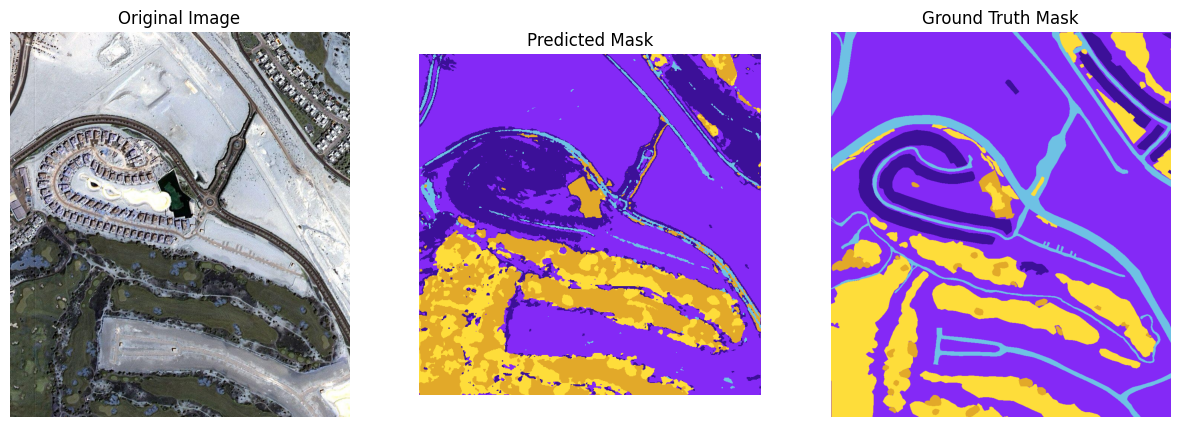

In [ ]:
predicted_rgb_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.int64)
for class_index, color in colormap.items():
    predicted_rgb_mask[predicted_mask == class_index] = color

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_rgb_mask)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth Mask")
plt.imshow(ground_truth_mask)
plt.axis('off')

plt.show()

In [ ]:
np.unique(predicted_mask)

array([0, 1, 2, 4, 5])

In [ ]:
np.unique(rgb_to_class_indices(ground_truth_mask))

array([0, 1, 2, 4, 5])

In [ ]:
import numpy as np
import torch

def calculate_mean_iou(predicted_mask, ground_truth_mask, num_classes):
    """
    Calculate the Mean Intersection over Union (Mean IoU).

    Args:
        predicted_mask (np.ndarray): The predicted segmentation mask.
        ground_truth_mask (np.ndarray): The ground truth segmentation mask.
        num_classes (int): The number of classes in the segmentation task.

    Returns:
        float: Mean IoU score.
    """
    # Initialize the intersection and union for each class
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    # Calculate the intersection and union for each class
    for class_index in range(num_classes):
        # Find the pixels where the prediction and ground truth match
        predicted_class = (predicted_mask == class_index)
        ground_truth_class = (ground_truth_mask == class_index)

        # Intersection
        intersection[class_index] = np.sum(predicted_class & ground_truth_class)

        # Union
        union[class_index] = np.sum(predicted_class | ground_truth_class)

    # Calculate IoU for each class, avoiding division by zero
    print(f"intersection : {intersection}")
    print(f"union : {union}")
    iou = intersection / union
    iou = np.nan_to_num(iou)  # Replace NaN with 0 for cases where union is 0

    # Return the mean IoU
    mean_iou = np.mean(iou)
    return mean_iou



In [ ]:
import cv2
if predicted_mask.ndim == 3:  # RGB format
    predicted_mask = rgb_to_class_indices(predicted_mask)
    # predicted_mask = transforms.Resize((512, 512))(Image.fromarray(ground_truth_mask))
if ground_truth_mask.ndim == 3:  # RGB format
    ground_truth_mask = cv2.resize(ground_truth_mask, (512, 512), interpolation=cv2.INTER_NEAREST)
    ground_truth_mask = rgb_to_class_indices(ground_truth_mask)
    print(ground_truth_mask.shape)

num_classes = len(colormap)  # Use the number of classes you defined
mean_iou = calculate_mean_iou(predicted_mask, ground_truth_mask, num_classes)
print(f"Mean IoU: {mean_iou:.4f}")




intersection : [ 17440.   6289. 120496.      0.   1104.   9971.]
union : [ 51674.  26213. 171936.      0.  50065.  69100.]
Mean IoU: 0.2408


<ipython-input-87-2d8bd0be0c3a>:35: RuntimeWarning: invalid value encountered in divide
  iou = intersection / union


In [ ]:
print(np.unique(ground_truth_mask))
print(np.unique(predicted_mask))


[0 1 2 4 5]
[0 1 2 4 5]


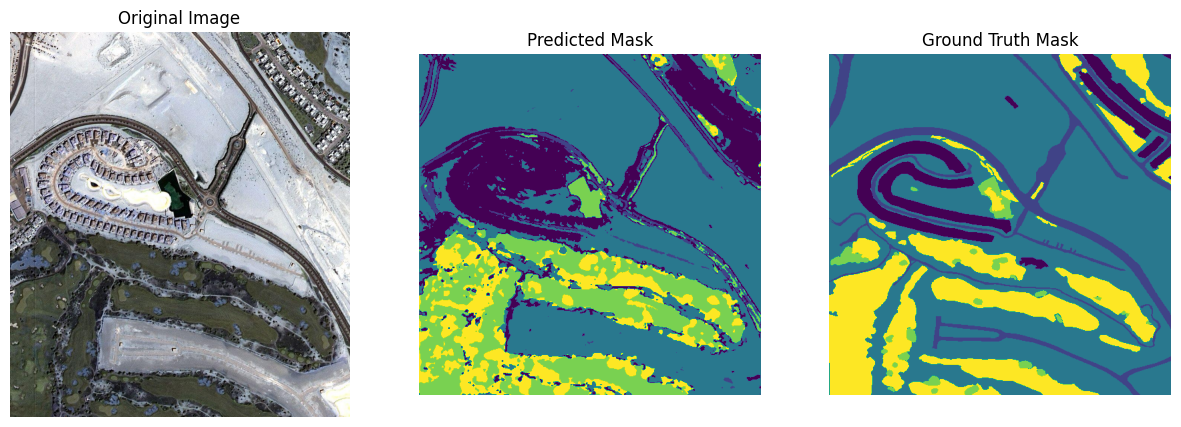

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth Mask")
plt.imshow(ground_truth_mask)
plt.axis('off')

plt.show()